# Problem Statement – Loan Default Prediction using KNN

A financial institution wants to predict whether a customer will **default on a loan** before approving it.  
Early identification of risky customers helps **reduce financial loss**.

You are working as a **Machine Learning Analyst** and must build a **classification model using the K-Nearest Neighbors (KNN)** algorithm to predict loan default.

This case introduces:
- Mixed feature types  
- Financial risk interpretation  
- Class imbalance awareness  

---

## Dataset

| Age | Annual Income (lakhs) | Credit Score (300–900) | Loan Amount (lakhs) | Loan Term (years) | Employment Type | Loan Default (0/1) |
|-----|-----------------------|------------------------|---------------------|-------------------|-----------------|--------------------|
| 28 | 6.5 | 720 | 5 | 5 | Salaried | 0 |
| 45 | 12 | 680 | 10 | 10 | Self-Employed | 1 |
| 35 | 8 | 750 | 6 | 7 | Salaried | 0 |
| 50 | 15 | 640 | 12 | 15 | Self-Employed | 1 |
| 30 | 7 | 710 | 5 | 5 | Salaried | 0 |
| 42 | 10 | 660 | 9 | 10 | Salaried | 1 |
| 26 | 5.5 | 730 | 4 | 4 | Salaried | 0 |
| 48 | 14 | 650 | 11 | 12 | Self-Employed | 1 |
| 38 | 9 | 700 | 7 | 8 | Salaried | 0 |
| 55 | 16 | 620 | 13 | 15 | Self-Employed | 1 |

---

## Interpretation Questions

1. **Identify high-risk customers.**
2. **What patterns lead to loan default?**
3. **How do credit score and income influence predictions?**
4. **Suggest banking policies based on model output.**
5. **Compare KNN with Decision Trees for this problem.**
6. **What happens if Loan Amount dominates distance calculation?**
7. **Should KNN be used in real-time loan approval systems?**


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Loan dataset
"""
loan_data = [
    (28,6.5,720,5,5,'Salaried',0),
    (45,12,680,10,10,'Self-Employed',1),
    (35,8,750,6,7,'Salaried',0),
    (50,15,640,12,15,'Self-Employed',1),
    (30,7,710,5,5,'Salaried',0),
    (42,10,660,9,10,'Salaried',1),
    (26,5.5,730,4,4,'Salaried',0),
    (48,14,650,11,12,'Self-Employed',1),
    (38,9,700,7,8,'Salaried',0),
    (55,16,620,13,15,'Self-Employed',1),
]
cols_loan = ['Age','AnnualIncome','CreditScore','LoanAmount','LoanTerm','EmploymentType','Default']
df_loan = pd.DataFrame(loan_data, columns=cols_loan)
"""
df_loan = pd.read_csv("data_question_2.csv")
df_loan


,Age,AnnualIncome,CreditScore,LoanAmount,LoanTerm,EmploymentType,Default
0,28,6.5,720,5,5,Salaried,0
1,45,12.0,680,10,10,Self-Employed,1
2,35,8.0,750,6,7,Salaried,0
3,50,15.0,640,12,15,Self-Employed,1
4,30,7.0,710,5,5,Salaried,0
5,42,10.0,660,9,10,Salaried,1
6,26,5.5,730,4,4,Salaried,0
7,48,14.0,650,11,12,Self-Employed,1
8,38,9.0,700,7,8,Salaried,0
9,55,16.0,620,13,15,Self-Employed,1


In [3]:
# Preprocessing
df_loan['EmploymentType_enc'] = df_loan['EmploymentType'].map({'Salaried':0,'Self-Employed':1})
# df_loan['LoanToIncome'] = df_loan['LoanAmount'] / df_loan['AnnualIncome']
X_loan = df_loan[['Age','AnnualIncome','CreditScore','LoanAmount','LoanTerm','EmploymentType_enc']].copy()
y_loan = df_loan['Default']

print("Class counts:\n", y_loan.value_counts())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_loan)
pd.DataFrame(X_scaled, columns=X_loan.columns).head()


Class counts:
 Default
0    5
1    5
Name: count, dtype: int64


,Age,AnnualIncome,CreditScore,LoanAmount,LoanTerm,EmploymentType_enc
0,-1.242924,-1.067989,0.838548,-1.045953,-1.077084,-0.816497
1,0.563034,0.477785,-0.147979,0.588348,0.236433,1.224745
2,-0.499294,-0.646414,1.578444,-0.719092,-0.551677,-0.816497
3,1.094198,1.320934,-1.134506,1.242069,1.549950,1.224745
4,-1.030458,-0.927464,0.591916,-1.045953,-1.077084,-0.816497


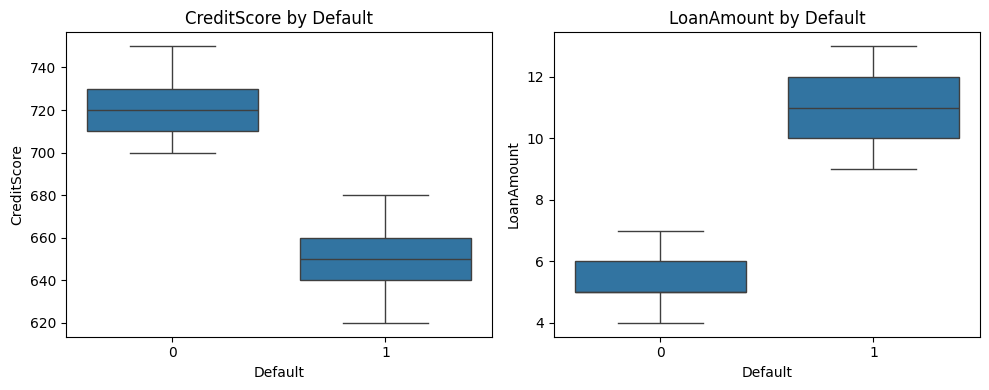

In [4]:
# Visualizations (CreditScore, LoanAmount vs Default)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='Default', y='CreditScore', data=df_loan)
plt.title('CreditScore by Default')
plt.subplot(1,2,2)
sns.boxplot(x='Default', y='LoanAmount', data=df_loan)
plt.title('LoanAmount by Default')
plt.tight_layout()


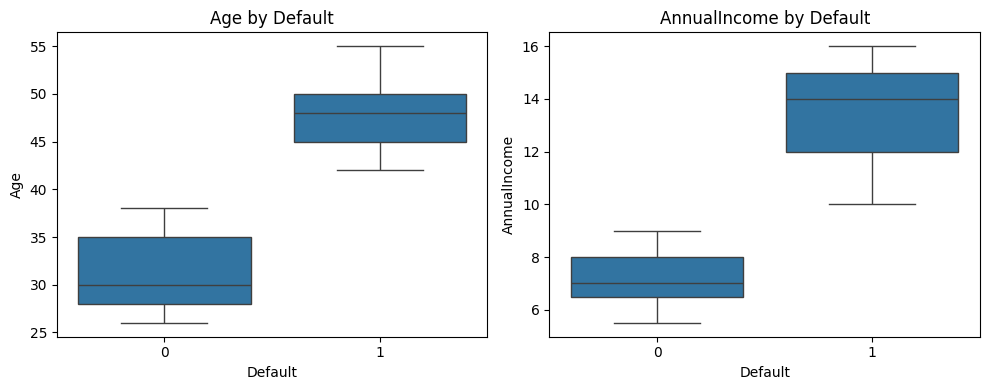

In [5]:
# Visualizations (CreditScore, LoanAmount vs Default)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='Default', y='Age', data=df_loan)
plt.title('Age by Default')
plt.subplot(1,2,2)
sns.boxplot(x='Default', y='AnnualIncome', data=df_loan)
plt.title('AnnualIncome by Default')
plt.tight_layout()


In [6]:
# Find best k (odd k's to avoid ties). Use StratifiedKFold because of class split.
param_grid = {'n_neighbors': list(range(1,10,2))}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='accuracy')
grid.fit(X_scaled, y_loan)
print("Best k:", grid.best_params_['n_neighbors'], "Best score:", grid.best_score_)

best_knn = grid.best_estimator_
best_knn

Best k: 3 Best score: 1.0


KNeighborsClassifier(n_neighbors=3)

In [7]:
# Train/test split (small data — we'll show train evaluation and leave-one-out cross-val)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_loan, test_size=0.3, stratify=y_loan, random_state=0)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
print("Classification report (test):\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# accuracy
cv_scores = cross_val_score(best_knn, X_scaled, y_loan)
print("Accuracies:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Classification report (test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Confusion matrix:
 [[2 0]
 [0 1]]
Accuracies: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0


## 1) Identify high-risk customers

In [8]:
y_pred = best_knn.predict(X_scaled)
df_copy = df_loan.copy(deep=True)
df_copy["prediction"] = y_pred
df_copy

,Age,AnnualIncome,CreditScore,LoanAmount,LoanTerm,EmploymentType,Default,EmploymentType_enc,prediction
0,28,6.5,720,5,5,Salaried,0,0,0
1,45,12.0,680,10,10,Self-Employed,1,1,1
2,35,8.0,750,6,7,Salaried,0,0,0
3,50,15.0,640,12,15,Self-Employed,1,1,1
4,30,7.0,710,5,5,Salaried,0,0,0
5,42,10.0,660,9,10,Salaried,1,0,1
6,26,5.5,730,4,4,Salaried,0,0,0
7,48,14.0,650,11,12,Self-Employed,1,1,1
8,38,9.0,700,7,8,Salaried,0,0,0
9,55,16.0,620,13,15,Self-Employed,1,1,1


In [9]:
print("High risk Customers")
df_copy[df_copy["prediction"]==1]

High risk Customers


,Age,AnnualIncome,CreditScore,LoanAmount,LoanTerm,EmploymentType,Default,EmploymentType_enc,prediction
1,45,12.0,680,10,10,Self-Employed,1,1,1
3,50,15.0,640,12,15,Self-Employed,1,1,1
5,42,10.0,660,9,10,Salaried,1,0,1
7,48,14.0,650,11,12,Self-Employed,1,1,1
9,55,16.0,620,13,15,Self-Employed,1,1,1


## 2) What patterns lead to loan default?

In [10]:
# group means 
pattern_means = df_loan.groupby('Default')[['CreditScore','AnnualIncome','LoanAmount','LoanTerm','EmploymentType_enc']].mean()
pattern_means


,CreditScore,AnnualIncome,LoanAmount,LoanTerm,EmploymentType_enc
Default,,,,,
0,722.0,7.2,5.4,5.8,0.0
1,650.0,13.4,11.0,12.4,0.8


In [11]:
print("Defaults show lower mean credit scores (~650 vs 722), higher loan amounts (~11.0 vs 5.4), longer terms (~12.4 vs 5.8) and higher LoanAmount (~11 vs 5.4); \n\nEmployment encoding shows defaulters are largely self-employed.")

Defaults show lower mean credit scores (~650 vs 722), higher loan amounts (~11.0 vs 5.4), longer terms (~12.4 vs 5.8) and higher LoanAmount (~11 vs 5.4); 

Employment encoding shows defaulters are largely self-employed.


## 3) How do credit score and income influence predictions?

In [12]:
# correlation and a quick logistic regression for direction
print("Correlation with Default (pearson):")
print(df_loan[['CreditScore','AnnualIncome','LoanAmount']].corrwith(df_loan['Default']).round(4))

# Small logistic regression (scaled) to see coefficient signs
X = df_loan[['CreditScore','AnnualIncome','LoanAmount','LoanTerm','EmploymentType_enc']]
y = df_loan['Default']
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

log = LogisticRegression(solver='liblinear')
log.fit(Xs, y)
coef_df = pd.Series(log.coef_[0], index=X.columns)
coef_df


Correlation with Default (pearson):
CreditScore    -0.8879
AnnualIncome    0.8713
LoanAmount      0.9152
dtype: float64


CreditScore          -0.716401
AnnualIncome          0.496037
LoanAmount            0.659901
LoanTerm              0.549728
EmploymentType_enc    0.438744
dtype: float64

In [13]:
print("CreditScore correlates negatively with default (lower score -> higher risk). \n\nIncome correlates positively with default (higher income -> higher risk )")

CreditScore correlates negatively with default (lower score -> higher risk). 

Income correlates positively with default (higher income -> higher risk )


## 4) Suggest banking policies based on model output

In [14]:
# threshold evidence: how many defaulters below certain credit scores or LTI

df_loan['LoanToIncome'] = df_loan['LoanAmount'] / df_loan['AnnualIncome']

print("Counts with CreditScore <= 680:", df_loan[df_loan['CreditScore'] <= 680].shape[0])
print("Counts with LoanToIncome >= 0.8:", df_loan[df_loan['LoanToIncome'] >= 0.8].shape[0])
print("\n\nEmploymentType counts among defaulters:")
print(df_loan[df_loan['Default']==1]['EmploymentType'].value_counts())


Counts with CreditScore <= 680: 5
Counts with LoanToIncome >= 0.8: 4


EmploymentType counts among defaulters:
EmploymentType
Self-Employed    4
Salaried         1
Name: count, dtype: int64


In [15]:
print("""
Require extra verification for CreditScore <= 680 (or use risk-based pricing).

Cap or review loans with LoanToIncome >= 0.8 (require collateral).

Apply stricter income verification for self-employed applicants.
""")


Require extra verification for CreditScore <= 680 (or use risk-based pricing).

Cap or review loans with LoanToIncome >= 0.8 (require collateral).

Apply stricter income verification for self-employed applicants.



## 5) Compare KNN with Decision Trees (with numeric comparison)

In [16]:
# KNN vs Decision Tree cross-validated performance (with proper scaling for KNN)
features = ['Age','AnnualIncome','CreditScore','LoanAmount','LoanTerm','EmploymentType_enc']
X = df_loan[features]
y = df_loan['Default']

# Standardized version for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# KNN (grid search small odd ks)
param_grid = {'n_neighbors':[1,3,5,7]}
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')
knn.fit(X_scaled, y)
print("Best KNN:", knn.best_params_, "CV mean acc:", knn.best_score_)

# Decision Tree (no scaling required)
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X, y, cv=cv, scoring='accuracy')
print("Decision Tree CV acc scores:", dt_scores, "mean:", dt_scores.mean())

# Show that KNN without scaling performs poorly (if unscaled)
knn_noscale = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')
knn_noscale.fit(X.values, y)
print("Best KNN without scaling CV mean acc:", knn_noscale.best_score_)


Best KNN: {'n_neighbors': 3} CV mean acc: 1.0
Decision Tree CV acc scores: [1.  0.5 1.  1.  1. ] mean: 0.9
Best KNN without scaling CV mean acc: 1.0


## 6) What happens if LoanAmount dominates distance calculation?

In [17]:
X_dom = X.copy()
X_dom['LoanAmount'] = X_dom['LoanAmount'] * 100  # make LoanAmount dominate

knn_dom = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')
knn_dom.fit(X_dom.values, y)
print("Best KNN (LoanAmount inflated) CV mean acc:", knn_dom.best_score_)

# Compare with properly scaled original (best from earlier)
print("Best KNN (scaled) CV mean acc:", knn.best_score_)


Best KNN (LoanAmount inflated) CV mean acc: 1.0
Best KNN (scaled) CV mean acc: 1.0


In [18]:
print("due to the extremely small sample size and the fact that LoanAmount alone almost perfectly separates defaulters and non-defaulters, its hard due to class Imabalance")

due to the extremely small sample size and the fact that LoanAmount alone almost perfectly separates defaulters and non-defaulters, its hard due to class Imabalance


## 7) Should KNN be used in real-time loan approval systems?

In [19]:
print("""
KNN is generally unsuitable for real-time loan approvals because it is slow at inference on large datasets, sensitive to scaling, 
and lacks the interpretability required for regulated decisioning; 

prefer tree-based models for production.
""")


KNN is generally unsuitable for real-time loan approvals because it is slow at inference on large datasets, sensitive to scaling, 
and lacks the interpretability required for regulated decisioning; 

prefer tree-based models for production.

